Estimate recovery fraction for synthetic multi-Gaussian fitting.

In [1]:
from astropy.io import fits
import astropy.units as u
import astropy.constants as c
import os
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import Projection
from scipy import ndimage as nd
from astropy.stats import histogram as astro_hist
from astropy.table import Table

# from galaxies import Galaxy

osjoin = os.path.join

repo_path = os.path.expanduser("~/ownCloud/project_code/ThickHIFitting/")

figures_path_png = osjoin(repo_path, "figures/png")
figures_path_pdf = osjoin(repo_path, "figures/pdf")


def save_figure(fig, plot_name, **kwargs):
    fig.savefig(f"{figures_path_pdf}/{plot_name}.pdf", **kwargs)
    fig.savefig(f"{figures_path_png}/{plot_name}.png", **kwargs)


paths_script = os.path.join(repo_path, "paths.py")
exec(compile(open(paths_script, "rb").read(), paths_script, 'exec'))

plotstyle_script = os.path.join(repo_path, "plotting_styles.py")
exec(compile(open(plotstyle_script, "rb").read(), plotstyle_script, 'exec'))

modsel_script = os.path.join(repo_path, "model_selection_tools.py")
exec(compile(open(modsel_script, "rb").read(), modsel_script, 'exec'))

output_path = osjoin(repo_path, 'simrecovery')


In [2]:
output_name = 'multigauss_synthetic_fitting_tests.csv'
tab = Table.read(osjoin(output_path, output_name))

# Save params and fit params separately.
data_save_file = "multigauss_synthetic_fitting_tests.npz"

# The compressed file is ~1.6 MB.
out = np.load(f"{output_path}/{data_save_file}")

mgauss_act_params = out['mgauss_act_params']
distinct_act = out['distinct_act']
mgauss_fit_params = out['mgauss_fit_params']
mgauss_fit_uncerts = out['mgauss_fit_uncerts']
distinct_fit = out['distinct_fit']

In [4]:
# Calculate the fraction of fitted components compared to the actual number

from sklearn.metrics import confusion_matrix

ncomp_act = tab['ncomp_act']
ncomp_fit = tab['ncomp_fit']

conmat = confusion_matrix(tab['ncomp_act'], tab['ncomp_fit'], normalize='true')

# conmat[conmat == 0] = np.NaN


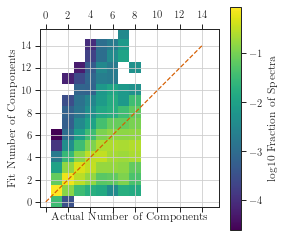

In [18]:
onecolumn_figure()

plt.matshow(np.log10(conmat.T), origin='lower', cmap='viridis', interpolation="none")
# plt.matshow(conmat.T, origin='lower', cmap='viridis', interpolation="none")
cbar = plt.colorbar()

# cbar.set_label("log10 Number of Spectra")
cbar.set_label("log10 Fraction of Spectra")

plt.plot([0, 14], [0, 14], 'r--')

plt.xlabel("Actual Number of Components")
plt.ylabel("Fit Number of Components")

plt.grid(True)

plt.tight_layout()


plot_name = 'mgauss_confmat_all'

save_figure(plt.gcf(), plot_name, bbox_inches='tight')

There is a large scatter which is smaller for fewer components.

However the blending is included and inherently uncertain. Make similar confusion matrices for distinct and blended components.

In [16]:
ncomp_act_distinct = np.tile(distinct_act.sum(1), (10, 1)).T.ravel()
ncomp_fit_distinct = distinct_fit.sum(1)

conmat_distinct = confusion_matrix(ncomp_act_distinct, ncomp_fit_distinct, normalize='true')



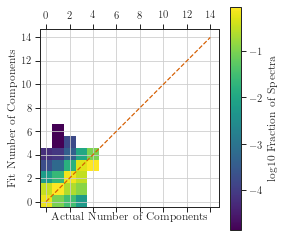

In [19]:
onecolumn_figure()

plt.matshow(np.log10(conmat_distinct.T), origin='lower', cmap='viridis', interpolation="none")
cbar = plt.colorbar()

# cbar.set_label("log10 Number of Spectra")
cbar.set_label("log10 Fraction of Spectra")

plt.plot([0, 14], [0, 14], 'r--')

plt.xlabel("Actual Number of Components")
plt.ylabel("Fit Number of Components")

plt.grid(True)

plt.tight_layout()

plot_name = 'mgauss_confmat_distinct'

save_figure(plt.gcf(), plot_name, bbox_inches='tight')

Distinct components are more closely clustered.

In [20]:
ncomp_act_blend = ncomp_act - ncomp_act_distinct
ncomp_fit_blend = ncomp_fit - ncomp_fit_distinct

conmat_blend = confusion_matrix(ncomp_act_blend, ncomp_fit_blend, normalize='true')

print(ncomp_act_blend.max(), ncomp_act_blend.min())
print(ncomp_fit_blend.max(), ncomp_fit_blend.min())


8 0
14 0


In [ ]:
print(conmat_distinct[:, 0])
print(conmat_blend[:, 0])
print(conmat[:, 0])

print(conmat.shape, conmat_blend.shape, conmat_distinct.shape)

In [ ]:
conmat_blend[0]

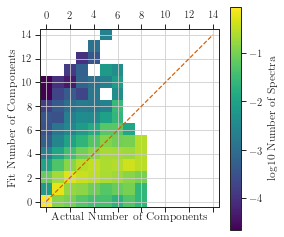

In [21]:
onecolumn_figure()

plt.matshow(np.log10(conmat_blend.T), origin='lower', cmap='viridis', interpolation="none")
cbar = plt.colorbar()

# cbar.set_label("log10 Number of Spectra")
cbar.set_label("log10 Number of Spectra")

plt.plot([0, 14], [0, 14], 'r--')

plt.xlabel("Actual Number of Components")
plt.ylabel("Fit Number of Components")

plt.grid(True)

plt.tight_layout()

plot_name = 'mgauss_confmat_blend'

save_figure(plt.gcf(), plot_name, bbox_inches='tight')

# There's a problem here b/c the full fits don't have any 1 actual component -> 10 blended components?

And here's where see most of the scatter. Next step is to start matching distinct components. We'll treat those as "mostly trustworthy" to derive recovery fraction.

How many components match the expected parameters?

In [22]:
# Loop through components. All, distinct and blend.

vel_min = -125 * u.km / u.s
vels_max = 125 * u.km / u.s

# Model averaged to final channel sizes set by observations
delta_v = 0.42 * u.km / u.s

vels = np.arange(vel_min.value, vels_max.value,
                 delta_v.value) * u.km / u.s

vels = vels.to(u.m / u.s).value

nspec = 10

matches_bool = []
matched_comps = []
matched_params = []

for j in range(mgauss_act_params.shape[0]):
    
    pars_act = mgauss_act_params[j].copy()
    pars_act = pars_act[:3 * ncomp_act[10 * j]]
    # Convert to m/s from km/s
    pars_act[1::3] *= 1000
    pars_act[2::3] *= 1000
    
    for i in range(nspec):
    
        pars_fit = mgauss_fit_params[nspec * j + i].copy()
        pars_fit = pars_fit[:3 * ncomp_fit[i]]
    
        # Matches between all components
        matches, matched_order, matched_pars = \
            match_components(vels, pars_act, pars_fit,
                             min_overlap_deviation=0.05,
                            test_print=False)
        
        matches_bool.append(matches)
        matched_comps.append(matched_order)
        matched_params.append(matched_pars)
    
#     print(matches)
#     print(matched_order)

In [23]:
# # Test case
# print(ncomp_act.shape)
# print(mgauss_act_params.shape)

# j = 1
# i = 0

# pars_act = mgauss_act_params[j].copy()
# pars_act = pars_act[:3 * ncomp_act[10 * j]]
# # Convert to m/s from km/s
# pars_act[1::3] *= 1000
# pars_act[2::3] *= 1000
    
# pars_fit = mgauss_fit_params[nspec * j + i].copy()
# pars_fit = pars_fit[:3 * ncomp_fit[i]]

# print(nspec * j + i)
# print(ncomp_act[j])
# print(pars_act)
# print(pars_fit)

# # Matches between all components
# matches, matched_order, matched_pars = \
#             match_components(vels, pars_act, pars_fit,
#                              min_overlap_deviation=0.05,
#                             test_print=False)
# print(matches)
# print(matched_order)
# print(matched_pars)


In [24]:
matched_params[-1]

array([   68.02509376,  8216.17567156, 47330.83640609])

In [25]:
num_matches_all = np.array([sum(match) for match in matches_bool])

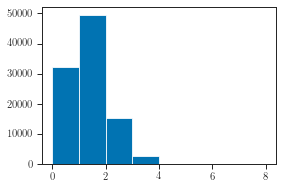

In [26]:
_ = plt.hist(num_matches_all, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8])

In [27]:
num_matches_all.max()

4

In [28]:
np.unique(num_matches_all)

array([0, 1, 2, 3, 4])

In [29]:
matches_bool[10]

array([ True, False])

In [30]:
matched_comps[10]

array([   0, 9999])

In [31]:
mgauss_fit_params[1]

array([ 6.84363327e+01, -4.84419774e+04,  9.98011813e+03,  2.76239984e+01,
        2.79470289e+03,  6.18314841e+03,  6.06643287e+00, -7.49365068e+04,
        1.61322136e+04,  3.73006788e+00, -4.15485209e+04,  5.30613119e+04,
        2.05882034e+01, -7.12963644e+03,  2.99381649e+04,  2.35071607e+01,
       -2.75411055e+04,  2.59615155e+04,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan])

In [32]:
mgauss_act_params[0]

array([ 45.94517353, -24.80661866,  34.63998745,  28.13705636,
         2.86248624,   6.28560123,  62.75633927, -48.34095931,
         9.5165728 ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

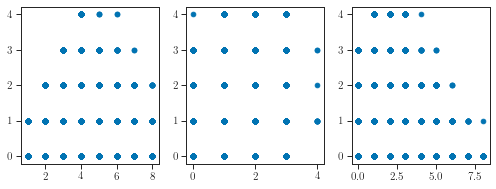

In [33]:
twocolumn_twopanel_figure()

plt.subplot(131)
plt.scatter(ncomp_act, num_matches_all)
plt.subplot(132)
plt.scatter(ncomp_act_distinct, num_matches_all)
plt.subplot(133)
plt.scatter(ncomp_act_blend, num_matches_all)


These aren't fully separated into distinct/blended, but there is a tendency of more matches with fewer blended components.

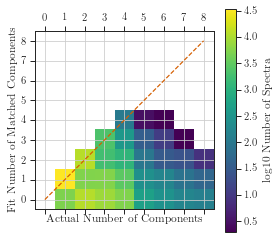

In [34]:
conmat_match = confusion_matrix(ncomp_act, num_matches_all) # normalize='true')

onecolumn_figure()

plt.matshow(np.log10(conmat_match.T), origin='lower', cmap='viridis', interpolation="none")
cbar = plt.colorbar()

cbar.set_label("log10 Number of Spectra")

plt.plot([0, 8], [0, 8], 'r--')

plt.xlabel("Actual Number of Components")
plt.ylabel("Fit Number of Matched Components")

plt.grid(True)

plt.tight_layout()

In [35]:
# Match distinct with matched components

num_matches_distinct = []
# matched_distincts = []

nspec = 10

for i, act_distinct in enumerate(distinct_act):

    for j in range(nspec):
        
        match = matches_bool[nspec * i + j]
    
    
        if not match.any():
            num_matches_distinct.append(0)
            continue
    
        num_matches_distinct.append(sum(act_distinct[:match.size] & match))


In [36]:
# act_distinct:match.size] # & match
len(num_matches_distinct)

100000

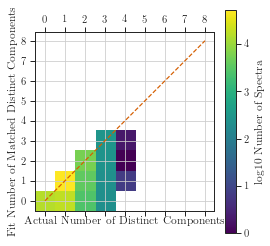

In [37]:
# Need to match the matched components to those that are distinct

# conmat_match_distinct = confusion_matrix(ncomp_act_distinct, num_matches_all) # normalize='true')
conmat_match_distinct = confusion_matrix(ncomp_act_distinct, num_matches_distinct) # normalize='true')

onecolumn_figure()

plt.matshow(np.log10(conmat_match_distinct.T), origin='lower', cmap='viridis', interpolation="none")
cbar = plt.colorbar()

cbar.set_label("log10 Number of Spectra")

plt.plot([0, 8], [0, 8], 'r--')

plt.xlabel("Actual Number of Distinct Components")
plt.ylabel("Fit Number of Matched Distinct Components")

plt.grid(True)

plt.tight_layout()

Not too bad, but more scatter than I had hoped for. At least we don't have MORE distinct components in the fits. That would be hard to explain.

Finding fewer distinct components will occur if (i) that component was not well-distinguished above noise in the fit; (ii) a single distinct component was fit with >1 components.

Now need to examine the parameter space of distinct components to see how much the recovery depends on parameters (i.e., narrow bright components _should_ be recovered well; is that the case?).

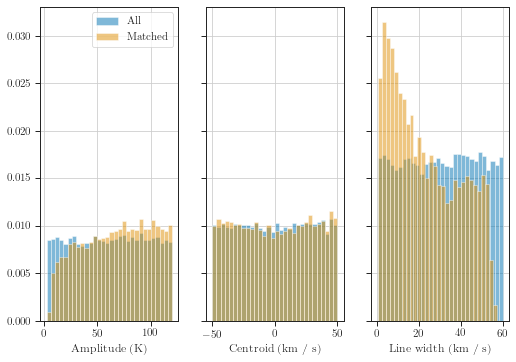

In [38]:
# Distribution of matched properties to total.
twocolumn_figure()

fig, axs = plt.subplots(1, 3, sharex=False, sharey=True)

all_pars = []
for pars, num in zip(mgauss_act_params, tab['ncomp_act'][::10]):

    all_pars.extend(pars[: 3 * num])
    
all_pars = np.array(all_pars)
    
# All matched to all
_ = axs[0].hist(all_pars[::3], bins=30, density=True, alpha=0.5, label='All')

_ = axs[1].hist(all_pars[1::3], bins=30, density=True, alpha=0.5)

_ = axs[2].hist(all_pars[2::3], bins=30, density=True, alpha=0.5)


# All matched components
all_matched_pars = []
for pars in matched_params:
    all_matched_pars.extend(list(pars))

all_matched_pars = np.array(all_matched_pars)
    
_ = axs[0].hist(all_matched_pars[::3], bins=30, density=True, alpha=0.5, label='Matched')

_ = axs[1].hist(all_matched_pars[1::3] / 1000., bins=30, density=True, alpha=0.5)

_ = axs[2].hist(all_matched_pars[2::3] / 1000., bins=30, density=True, alpha=0.5)

axs[0].set_xlabel("Amplitude (K)")
axs[1].set_xlabel("Centroid (km / s)")
axs[2].set_xlabel("Line width (km / s)")

axs[0].legend()

[ax.grid(True) for ax in axs]

plot_name = 'mgauss_matched_all_densityhist'

save_figure(fig, plot_name, bbox_inches='tight')


This is what I'm expecting: no recovery dependence on centroid (indep't of shape) but a slight preference for large amplitude and small line widths (setting the shape).

How does this change for distinct and blended components?

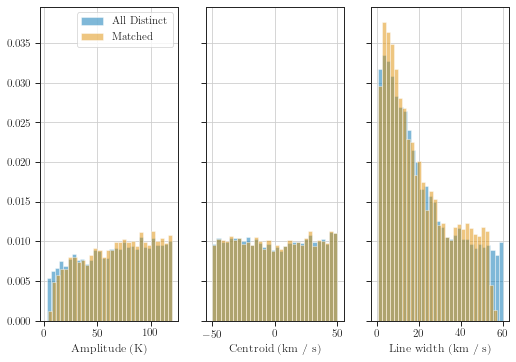

In [39]:
# Distribution of matched properties to total.
twocolumn_figure()

# fig, axs = plt.subplots(1, 4, sharex=False, )#sharey=True)
fig, axs = plt.subplots(1, 3, sharex=False, sharey=True)

all_pars_distinct = []
for ii, pars in enumerate(mgauss_act_params):

    num_distinct = distinct_act[ii]
    
    for jj in range(nspec):
    
        for nc in np.where(num_distinct)[0]:
            all_pars_distinct.extend(pars[3 * nc: 3 * nc + 3])
    
all_pars_distinct = np.array(all_pars_distinct)

all_pars_intint_distinct = np.sqrt(2 * np.pi) * all_pars_distinct[::3] * all_pars_distinct[2::3]
    
# All matched to all
_ = axs[0].hist(all_pars_distinct[::3], bins=30, density=True, alpha=0.5, label='All Distinct')

_ = axs[1].hist(all_pars_distinct[1::3], bins=30, density=True, alpha=0.5)

_ = axs[2].hist(all_pars_distinct[2::3], bins=30, density=True, alpha=0.5)

# _ = axs[3].hist(all_pars_intint_distinct, bins=30, density=True, alpha=0.5)


# All matched components
all_matched_pars_distinct = []
for ii, pars in enumerate(mgauss_act_params):


    for jj in range(nspec):

        ncomp = tab['ncomp_act'][nspec * ii + jj]
        
        num_distinct = distinct_act[ii][:ncomp]
        
        matches_i = matches_bool[nspec * ii + jj]
    
        for nc in np.where(np.logical_and(num_distinct, matches_i))[0]:
            all_matched_pars_distinct.extend(pars[3 * nc: 3 * nc + 3])
    
all_matched_pars_distinct = np.array(all_matched_pars_distinct)

all_matched_pars_intint_distinct = np.sqrt(2 * np.pi) * all_matched_pars_distinct[::3] * all_matched_pars_distinct[2::3]


_ = axs[0].hist(all_matched_pars_distinct[::3], bins=30, density=True, alpha=0.5, label='Matched')

_ = axs[1].hist(all_matched_pars_distinct[1::3], bins=30, density=True, alpha=0.5)

_ = axs[2].hist(all_matched_pars_distinct[2::3], bins=30, density=True, alpha=0.5)

# _ = axs[3].hist(all_matched_pars_intint_distinct, bins=30, density=True, alpha=0.5)

axs[0].set_xlabel("Amplitude (K)")
axs[1].set_xlabel("Centroid (km / s)")
axs[2].set_xlabel("Line width (km / s)")
# axs[3].set_xlabel("Integrated Intensity\n(K km / s)")

axs[0].legend()

[ax.grid(True) for ax in axs]

plot_name = 'mgauss_matched_distinct_densityhist'

save_figure(fig, plot_name, bbox_inches='tight')

In [40]:
# Add in blended version here. Less critical, though

In [41]:
amp_bins = np.arange(2., 120., 3.)

lwidth_bins = np.arange(0.4, 60., 0.8)

intint_bins = np.arange(3, 18000, 100)
# intint_bins = np.arange(3, 18000, 600)
# print(all_pars_intint_distinct.min(), all_pars_intint_distinct.max())

amp_hist_distinct = astro_hist(all_pars_distinct[::3], bins=amp_bins)[0]
amp_hist_distinct_matched = astro_hist(all_matched_pars_distinct[::3], bins=amp_bins)[0]

lwidth_hist_distinct = astro_hist(all_pars_distinct[2::3], bins=lwidth_bins)[0]
lwidth_hist_distinct_matched = astro_hist(all_matched_pars_distinct[2::3], bins=lwidth_bins)[0]

intint_hist_distinct = astro_hist(all_pars_intint_distinct, bins=intint_bins)[0]
intint_hist_distinct_matched = astro_hist(all_matched_pars_intint_distinct, bins=intint_bins)[0]


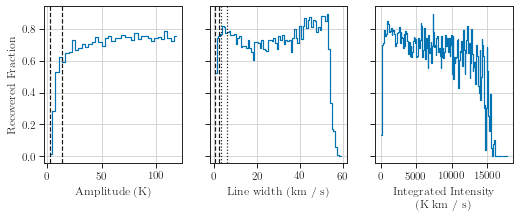

In [42]:
twocolumn_twopanel_figure()

fig, axs = plt.subplots(1, 3, sharey=True)

axs[0].plot(0.5 * (amp_bins[1:] + amp_bins[:-1]), amp_hist_distinct_matched / amp_hist_distinct,
            drawstyle='steps-mid')

axs[1].plot(0.5 * (lwidth_bins[1:] + lwidth_bins[:-1]), lwidth_hist_distinct_matched / lwidth_hist_distinct,
            drawstyle='steps-mid')

axs[2].plot(0.5 * (intint_bins[1:] + intint_bins[:-1]), intint_hist_distinct_matched / intint_hist_distinct,
            drawstyle='steps-mid')

axs[0].set_xlabel("Amplitude (K)")
axs[1].set_xlabel("Line width (km / s)")
axs[2].set_xlabel("Integrated Intensity\n(K km / s)")

axs[0].set_ylabel("Recovered Fraction")

axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

# Helpful noise limits and such
axs[0].axvline(2.8, color='k', linestyle='--')
axs[0].axvline(5 * 2.8, color='k', linestyle='--')


axs[1].axvline(0.42, color='k', linestyle='--')
axs[1].axvline(0.42 * 5, color='k', linestyle='--')

axs[1].axvline(3, color='k', linestyle=':')
axs[1].axvline(6, color='k', linestyle=':')



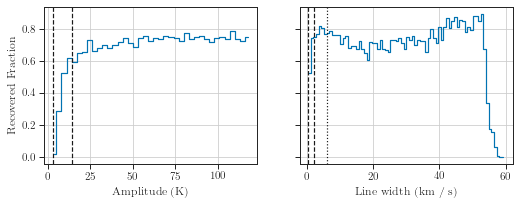

In [43]:
twocolumn_twopanel_figure()

fig, axs = plt.subplots(1, 2, sharey=True)

axs[0].plot(0.5 * (amp_bins[1:] + amp_bins[:-1]), amp_hist_distinct_matched / amp_hist_distinct,
            drawstyle='steps-mid')

axs[1].plot(0.5 * (lwidth_bins[1:] + lwidth_bins[:-1]), lwidth_hist_distinct_matched / lwidth_hist_distinct,
            drawstyle='steps-mid')

axs[0].set_xlabel("Amplitude (K)")
axs[1].set_xlabel("Line width (km / s)")

axs[0].set_ylabel("Recovered Fraction")

axs[0].grid(True)
axs[1].grid(True)

# Helpful noise limits and such
axs[0].axvline(2.8, color='k', linestyle='--')
axs[0].axvline(5 * 2.8, color='k', linestyle='--')


axs[1].axvline(0.42, color='k', linestyle='--')
axs[1].axvline(0.42 * 5, color='k', linestyle='--')

# axs[1].axvline(3, color='k', linestyle=':')
axs[1].axvline(6, color='k', linestyle=':')


plot_name = 'mgauss_matched_distinct_recoveryfrac'

save_figure(fig, plot_name, bbox_inches='tight')

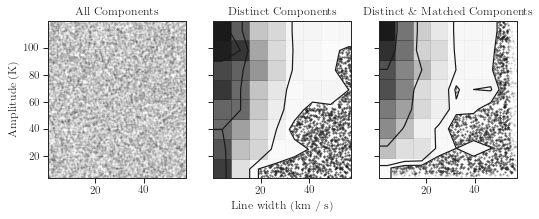

In [44]:
from corner import hist2d

twocolumn_twopanel_figure()

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)

hist2d(all_pars[2::3],
       all_pars[::3],
       bins=10, ax=axs[0],
       plot_contours=False,
       plot_density=False)


hist2d(all_pars_distinct[2::3],
       all_pars_distinct[::3],
       bins=[8, 8], ax=axs[1],
       plot_contours=True,
       plot_density=True)

hist2d(all_matched_pars_distinct[2::3],
       all_matched_pars_distinct[::3],
       bins=[8, 8], ax=axs[2],
       plot_contours=True,
       plot_density=True)

axs[0].set_title("All Components")
axs[1].set_title("Distinct Components")
axs[2].set_title("Distinct \& Matched Components")

axs[0].set_ylabel("Amplitude (K)")
# axs[0].set_xlabel("Line width (km / s)")
axs[1].set_xlabel("Line width (km / s)")


plot_name = 'mgauss_matched_hist2d_all_distinct_matched'

save_figure(fig, plot_name, bbox_inches='tight')